# Standard deviations of residual stellar parameters with more accurate filter values, now examined filter-by-filter to see which ones contribute the most:

In [1]:
%matplotlib inline

import numpy as np
import matplotlib.pylab as plt
from scipy.stats import binned_statistic
from sklearn.neighbors import KDTree

In [2]:
plt.style.use('default')
plt.style.use('ggplot')

In [3]:
# our stellar models:

with np.load('model_atm_mags.npz') as nump_zip:
    model_atm_mags = nump_zip['model_atm_mags']

In [4]:
# our "data":

temp = np.load('truth_catalog.npz')
truth_catalog = temp['truth_catalog'].copy()
temp.close()

## Bring the Noise:

In [5]:
def treeMaker(model_colors, observed_colors, true_catalog = None, catalog=None, parameter=None,
             parameter2=None, parameter3=None
             ):
    '''
    Parameters:
    
    model_colors : np.ndarray 
    must be [n_features, n_samples]; doesn't make sense but that's how I wrote it
    
    observed_colors : np.ndarray
    also must be [n_features, n_samples]; see above
    
    true_catalog : np.ndarray
    catalog : np.ndarray
    parameter : str
    parameter2 : str
    parameter3 : str
    
    The numpy arrays that you put in have to be of the form (samples, features) for it to work properly.
    Also the numpy arrays have to be numpy arrays.
    
    Makes a KD tree with the model stellar colors and queries that database for index of nearest neighbor. 
    
    Returns:
    
    ind : list or something
    residual(optional) : np.ndarray
    '''
    
    # keep getting a warning from a numpy/python standoff 
    # that isn't actually an issue so I want to shut it up:

    import warnings
    warnings.simplefilter(action='ignore', category=FutureWarning)
    
    residual = None
    residual2 = None
    residual3 = None
    
    if type(model_colors) == np.ndarray:
        try:
            tree = KDTree(model_colors.T)
            dist, ind = tree.query(observed_colors.T, k=1)
            ind = ind[:,0]

            if catalog != None and true_catalog != None:
                residual = np.array(true_catalog[parameter]-catalog[parameter][ind])
                
                if parameter2 != None:
                    residual2 = np.array(true_catalog[parameter2]-catalog[parameter2][ind])
                    
                if parameter3 != None:
                    residual3 = np.array(true_catalog[parameter3]-catalog[parameter3][ind])
        except:
            
            # if input arrays consist of only one color:
            tree = KDTree(model_colors.T.reshape(-1,1))
            dist, ind = tree.query(observed_colors.T.reshape(-1,1), k=1)
            ind = ind[:,0]

            if catalog != None and true_catalog != None:
                residual = np.array(true_catalog[parameter]-catalog[parameter][ind])
                
                if parameter2 != None:
                    residual2 = np.array(true_catalog[parameter2]-catalog[parameter2][ind])
                    
                if parameter3 != None:
                    residual3 = np.array(true_catalog[parameter3]-catalog[parameter3][ind])
    
    if type(model_colors) != np.ndarray or type(observed_colors) != np.ndarray:
        raise TypeError('Need to feed it arrays.')
        
    return(ind, residual, residual2, residual3)

In [6]:
def mag_error(m, snr):
    # https://www.eso.org/~ohainaut/ccd/sn.html
    dmag = 2.5*np.log10(1.+1./snr)
    return dmag

In [7]:
def alternateSNR(C_m, m_sky, magnitude, N):
    """
    Gives a SNR for a star based on N LSST observations & C_M plus m_sky in a particular filter.
    """
    m5 = C_m + 0.5*(m_sky-21)
    snr = 5.*10.**(-0.4*(magnitude-m5))
    snr = np.sqrt(N) * snr
    return(snr)

In [8]:
def binnedFitParams(true_mags, true_param, model_param, fit_indices, bin_len):
    
    """
    Bins a stellar parameter according to a list of magnitiudes. Also needs the indices from whichever KD-tree
    is being used. Also the length of each bin. Outputs binned magnitudes, standard deviation of each model_parameter
    bin, and average value of the parameter in each bin. That's as close to proper docstrings as this is going
    to get.
    """
    
    bins = np.arange(np.min(true_mags), np.max(true_mags), bin_len)

    digitize = np.digitize(true_mags, bins)

    bin_std = [
        np.std((true_param - model_param[fit_indices])[digitize == i]) for i in range(len(bins))
    ]

    # editing so it's the residuals rather than the model_parameter itself:
    
    bin_means = [
        (true_param - model_param[fit_indices])[digitize == i].mean() for i in range(len(bins))
    ]

    param_std = np.array(bin_std)[np.where(np.isnan(bin_means) == False)]

    mag_bins = np.array(bins)[np.where(np.isnan(bin_means) == False)]

    param_bin_means = np.array(bin_means)[np.where(np.isnan(bin_means) == False)]
    
    return(mag_bins, param_std, param_bin_means)

## Hardcoding in sky brightness and some other parameters:

In [9]:
# Wavelengths: 378, 395, 410, 430, 515, 660, 861 nm

nb_skymags = [22.63060826, 22.66559093, 22.39495818, 22.37808949, 21.89181356, 21.22310616, 19.36278739]

In [10]:
# u g r i z y

bb_skymags = [22.72624638, 22.0279839, 21.08485684, 20.25334748, 18.15891063, 19.33414126]

Might as well make use of that latex table output cell in syseng_throughputs, as I keep needing to refer to it. Turns out printing latex tables in jupyter markdown is weirdly difficult. Whatever, I can read the parts that I need to read.

\begin{array}{lrrrrr}
\toprule
{} &         Cm &  dCm\_infinity &         m5 &  m5\_fid &  m5\_min \\
\midrule
u    &  23.066504 &      0.631432 &  23.764100 &    23.9 &    23.4 \\
g    &  24.414254 &      0.179279 &  24.806431 &    25.0 &    24.6 \\
r    &  24.438509 &      0.097058 &  24.351669 &    24.7 &    24.3 \\
i    &  24.325059 &      0.070576 &  23.919008 &    24.0 &    23.6 \\
z    &  24.157261 &      0.048230 &  23.339608 &    23.3 &    22.9 \\
y    &  23.730152 &      0.036647 &  22.446768 &    22.1 &    21.7 \\
F378 &  20.844838 &      1.608560 &  21.583480 &  -666.0 &  -666.0 \\
F395 &  20.993904 &      1.552447 &  21.697387 &  -666.0 &  -666.0 \\
F410 &  22.085356 &      1.029328 &  22.619361 &  -666.0 &  -666.0 \\
F430 &  22.209414 &      0.995208 &  22.751224 &  -666.0 &  -666.0 \\
F515 &  22.447477 &      0.830243 &  22.772305 &  -666.0 &  -666.0 \\
F660 &  22.429329 &      0.721907 &  22.454270 &  -666.0 &  -666.0 \\
F861 &  23.314274 &      0.182961 &  22.572141 &  -666.0 &  -666.0 \\
\bottomrule
\end{array}

That constant thing that you have to add but I don't know what it actually is:

In [11]:
# Taking this opportunity to make the broadband filters' values more precise as well:

C_m = [23.066504, 24.414254, 24.438509, 24.325059, 24.157261, 23.730152]

# Yeah look at that these numbers are way different than whatever the nearest broadband filter is:

C_m_nb = [20.844838, 20.993904, 22.085356, 22.209414, 22.447477, 22.429329, 23.314274]

Number of exposures for broad and narrow bands at 1 & 10 years:

In [12]:
# number of total survey exposures in each (broadband) filter:

expnos1yr = [14623, 16330, 39324, 30745, 68542, 57904]

expnos = [177538, 234144, 515172, 514481, 486208, 445157]

In [13]:
# number of total exposures for a particular star in each filter:

star_exp_per_filt = 825*np.array([filt/np.sum(expnos) for filt in expnos])

star_exp_per_filt_1yr = 83*np.array([filt/np.sum(expnos1yr) for filt in expnos1yr])

# for narrow bands (just making these up):
# Maybe redo these? idk I did actually try tweaking them quite a bit when I was first writing this notebook
# and it didn't really seem to have all that mcuh effect... so maybe not worth bothering with?

nb_N_1yr = [3, 3, 6, 9, 9, 8, 6]
nb_N = [30, 30, 90, 90, 90, 80, 70]

In [14]:
mag_names = ['u', 'g', 'r', 'i', 'z', 'y']

NB_names = ['F378', 'F395', 'F410', 'F430', 'F515', 'F660', 'F861']

## Model Mags: 

In [15]:
model_color1 = model_atm_mags['u'] - model_atm_mags['g']
model_color2 = model_atm_mags['g'] - model_atm_mags['r']
model_color3 = model_atm_mags['r'] - model_atm_mags['i']
model_color4 = model_atm_mags['i'] - model_atm_mags['z']
model_color5 = model_atm_mags['z'] - model_atm_mags['y']

colormodel = np.array(
    [model_color1, model_color2, model_color3, model_color4, model_color5]
)

In [16]:
model_ncolor0 = model_atm_mags['F861'] - model_atm_mags['z']
model_ncolor1 = model_atm_mags['r'] - model_atm_mags['F660']
model_ncolor2 = model_atm_mags['g'] - model_atm_mags['F515']
model_ncolor3 = model_atm_mags['F430'] - model_atm_mags['g']
model_ncolor4 = model_atm_mags['F410'] - model_atm_mags['g']
model_ncolor5 = model_atm_mags['u'] - model_atm_mags['F395']
model_ncolor6 = model_atm_mags['u'] - model_atm_mags['F378']

#ncolormodel = np.array(
#    [model_ncolor0, model_ncolor1, model_ncolor2, model_ncolor3, model_ncolor4, model_ncolor5, model_ncolor6]
#).T

## Getting Observed Mags:

Broad band, 10 years:

In [17]:
# Set the random number seed to make things repeatable.

np.random.seed(42)

# Let's make some as-observed mags.

bbmagerr = []

bb_observations = np.zeros(truth_catalog.size, dtype=list(zip(mag_names, [float]*len(mag_names))))

for ii in range(len(bb_skymags)):
    
    # SNR for a filter:
    
    snrs = alternateSNR(C_m[ii], bb_skymags[ii], truth_catalog[mag_names[ii]], star_exp_per_filt[ii])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[mag_names[ii]], snrs)
    
    bbmagerr.append([mag_errors_realize])
    
    # 'Observed' mags for each star (original mag + error)
    
    bb_observations[mag_names[ii]] = truth_catalog[mag_names[ii]] + np.random.randn(truth_catalog[mag_names[ii]].size)*mag_errors_realize

10 Year Narrow Bands:

In [18]:
# Let's make some as-observed mags.

nbmagerr = []

nb_observations = np.zeros(truth_catalog.size, dtype=list(zip(NB_names, [float]*len(NB_names))))

for ii in range(len(nb_skymags)):
    
    # SNR for a filter:
    
    snrs = alternateSNR(C_m_nb[ii], nb_skymags[ii], truth_catalog[NB_names[ii]], nb_N[ii])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[NB_names[ii]], snrs)
    
    nbmagerr.append([mag_errors_realize])
    
    # 'Observed' mags for each star (original mag + error)
    
    nb_observations[NB_names[ii]] = truth_catalog[NB_names[ii]] + np.random.randn(truth_catalog[NB_names[ii]].size)*mag_errors_realize

BB 1 year:

In [19]:
np.random.seed(42)

# Let's make some as-observed mags.

bbmagerr1yr = []

bb_observations1yr = np.zeros(truth_catalog.size, dtype=list(zip(mag_names, [float]*len(mag_names))))

for ii in range(len(bb_skymags)):
    
    # SNR for a filter:
    
    snrs = alternateSNR(C_m[ii], bb_skymags[ii], truth_catalog[mag_names[ii]], star_exp_per_filt_1yr[ii])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[mag_names[ii]], snrs)
    
    bbmagerr1yr.append([mag_errors_realize])
    
    # 'Observed' mags for each star (original mag + error)
    
    bb_observations1yr[mag_names[ii]] = truth_catalog[mag_names[ii]] + np.random.randn(truth_catalog[mag_names[ii]].size)*mag_errors_realize

NB 1 year:

In [20]:
nbmagerr1yr = []

nb_observations1yr = np.zeros(truth_catalog.size, dtype=list(zip(NB_names, [float]*len(NB_names))))

for ii in range(len(nb_skymags)):
    
    # SNR for a filter:
    
    snrs = alternateSNR(C_m_nb[ii], nb_skymags[ii], truth_catalog[NB_names[ii]], nb_N_1yr[ii])
    
    # Magnitude errors for each star
    
    mag_errors_realize = mag_error(truth_catalog[NB_names[ii]], snrs)
    
    nbmagerr1yr.append([mag_errors_realize])
    
    # 'Observed' mags for each star (original mag + error)
    
    nb_observations1yr[NB_names[ii]] = truth_catalog[NB_names[ii]] + np.random.randn(truth_catalog[NB_names[ii]].size)*mag_errors_realize

Noise added, now making the actual observed colors:

In [21]:
early_nbobscolor1 = nb_observations1yr['F861'] - bb_observations1yr['z']
early_nbobscolor2 = bb_observations1yr['r'] - nb_observations1yr['F660']
early_nbobscolor3 = bb_observations1yr['g'] - nb_observations1yr['F515']
early_nbobscolor4 = nb_observations1yr['F430'] - bb_observations1yr['g']
early_nbobscolor5 = nb_observations1yr['F410'] - bb_observations1yr['g']
early_nbobscolor6 = bb_observations1yr['u'] - nb_observations1yr['F395']
early_nbobscolor7 = bb_observations1yr['u'] - nb_observations1yr['F378']

#nbobs_colors = np.array([early_nbobscolor1, early_nbobscolor2, early_nbobscolor3, early_nbobscolor4, early_nbobscolor5, early_nbobscolor6, early_nbobscolor7]).T

In [22]:
nbobscolor1 = nb_observations['F861'] - bb_observations['z']
nbobscolor2 = bb_observations['r'] - nb_observations['F660']
nbobscolor3 = bb_observations['g'] - nb_observations['F515']
nbobscolor4 = nb_observations['F430'] - bb_observations['g']
nbobscolor5 = nb_observations['F410'] - bb_observations['g']
nbobscolor6 = bb_observations['u'] - nb_observations['F395']
nbobscolor7 = bb_observations['u'] - nb_observations['F378']

#nbobs_colors = np.array([nbobscolor1, nbobscolor2, nbobscolor3, nbobscolor4, nbobscolor5, nbobscolor6, nbobscolor7]).T

In [23]:
early_obscolor1 = bb_observations1yr['u'] - bb_observations1yr['g'] # u-g
early_obscolor2 = bb_observations1yr['g'] - bb_observations1yr['r'] # g-r
early_obscolor3 = bb_observations1yr['r'] - bb_observations1yr['i'] # r-i
early_obscolor4 = bb_observations1yr['i'] - bb_observations1yr['z'] # i-z
early_obscolor5 = bb_observations1yr['z'] - bb_observations1yr['y'] # z-y

#early_obscolors = np.array([early_obscolor1, early_obscolor2, early_obscolor3, early_obscolor4, early_obscolor5]).T

In [24]:
obscolor1 = bb_observations['u'] - bb_observations['g'] # u-g
obscolor2 = bb_observations['g'] - bb_observations['r'] # g-r
obscolor3 = bb_observations['r'] - bb_observations['i'] # r-i
obscolor4 = bb_observations['i'] - bb_observations['z'] # i-z
obscolor5 = bb_observations['z'] - bb_observations['y'] # z-y

obs_colors = np.array([obscolor1, obscolor2, obscolor3, obscolor4, obscolor5])

## Indices and residuals: 

In [25]:
# ugrizy 10 years

color1 = treeMaker(
    model_color1, obscolor1, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
color2 = treeMaker(
    model_color2, obscolor2, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
color3 = treeMaker(
    model_color3, obscolor3, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
color4 = treeMaker(
    model_color4, obscolor4, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
color5 = treeMaker(
    model_color5, obscolor5, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)

In [26]:
# narrowbands at 10 years

nbcolor1 = treeMaker(
    model_ncolor0, nbobscolor1, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
nbcolor2 = treeMaker(
    model_ncolor1, nbobscolor2, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
nbcolor3 = treeMaker(
    model_ncolor2, nbobscolor3, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
nbcolor4 = treeMaker(
    model_ncolor3, nbobscolor4, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
nbcolor5 = treeMaker(
    model_ncolor4, nbobscolor5, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
nbcolor6 = treeMaker(
    model_ncolor5, nbobscolor6, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)
nbcolor7 = treeMaker(
    model_ncolor6, nbobscolor7, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff', parameter2='gravity', parameter3='log_Z'
)

# The Main Event:

10 years:

In [27]:
# nb colors:

nb_col1_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], nbcolor1[0], 1.0)
nb_col1_std = nb_col1_teff[1]
nb_col1_mag = nb_col1_teff[0]
nb_col1_temp = nb_col1_teff[2]
nb_col1_teff_residuals = nbcolor1[1]

nb_col2_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], nbcolor2[0], 1.0)
nb_col2_std = nb_col2_teff[1]
nb_col2_mag = nb_col2_teff[0]
nb_col2_temp = nb_col2_teff[2]
nb_col2_teff_residuals = nbcolor2[1]

nb_col3_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], nbcolor3[0], 1.0)
nb_col3_std = nb_col3_teff[1]
nb_col3_mag = nb_col3_teff[0]
nb_col3_temp = nb_col3_teff[2]
nb_col3_teff_residuals = nbcolor3[1]

nb_col4_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], nbcolor4[0], 1.0)
nb_col4_std = nb_col4_teff[1]
nb_col4_mag = nb_col4_teff[0]
nb_col4_temp = nb_col4_teff[2]
nb_col4_teff_residuals = nbcolor4[1]

nb_col5_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], nbcolor5[0], 1.0)
nb_col5_std = nb_col5_teff[1]
nb_col5_mag = nb_col5_teff[0]
nb_col5_temp = nb_col5_teff[2]
nb_col5_teff_residuals = nbcolor5[1]

nb_col6_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], nbcolor6[0], 1.0)
nb_col6_std = nb_col6_teff[1]
nb_col6_mag = nb_col6_teff[0]
nb_col6_temp = nb_col6_teff[2]
nb_col6_teff_residuals = nbcolor6[1]

nb_col7_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], nbcolor7[0], 1.0)
nb_col7_std = nb_col7_teff[1]
nb_col7_mag = nb_col7_teff[0]
nb_col7_temp = nb_col7_teff[2]
nb_col7_teff_residuals = nbcolor7[1]

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

In [28]:
# ugrizy (colors though):

col1_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], color1[0], 1.0)
col1_std = col1_teff[1]
col1_mag = col1_teff[0]
col1_temp = col1_teff[2]
col1_teff_residuals = color1[1]

col2_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], color2[0], 1.0)
col2_std = col2_teff[1]
col2_mag = col2_teff[0]
col2_temp = col2_teff[2]
col2_teff_residuals = color2[1]

col3_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], color3[0], 1.0)
col3_std = col3_teff[1]
col3_mag = col3_teff[0]
col3_temp = col3_teff[2]
col3_teff_residuals = color3[1]

col4_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], color4[0], 1.0)
col4_std = col4_teff[1]
col4_mag = col4_teff[0]
col4_temp = col4_teff[2]
col4_teff_residuals = color4[1]

col5_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], color5[0], 1.0)
col5_std = col5_teff[1]
col5_mag = col5_teff[0]
col5_temp = col5_teff[2]
col5_teff_residuals = color5[1]

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.


Here goes:

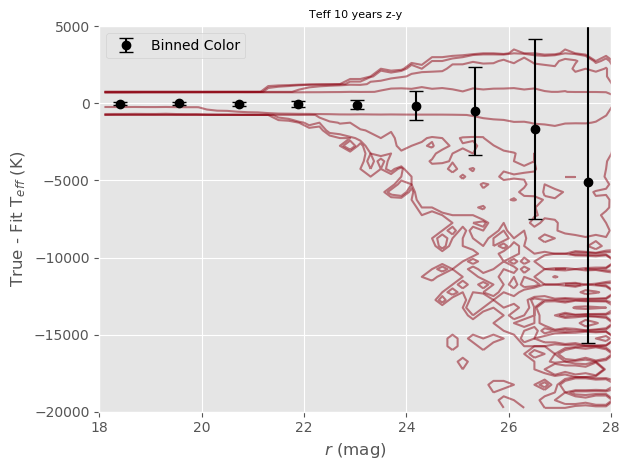

In [29]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], col5_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='xkcd:Crimson', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  col5_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  col5_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years z-y', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/z-y_teff.pdf')

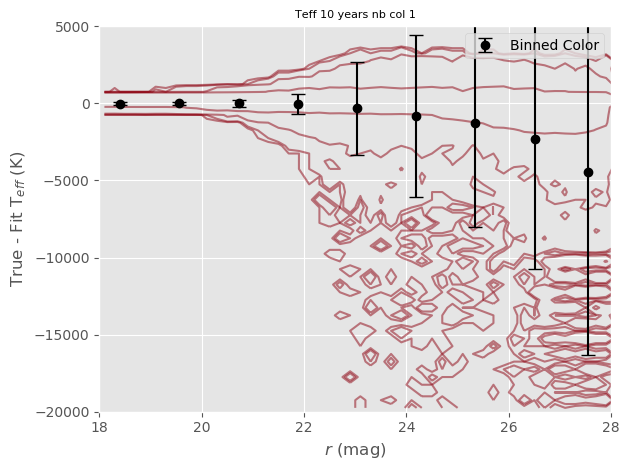

In [30]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_col1_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='xkcd:Crimson', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  nb_col1_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  nb_col1_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years nb col 1', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/nbcol1.pdf')

In [31]:
# well that one looks like crap

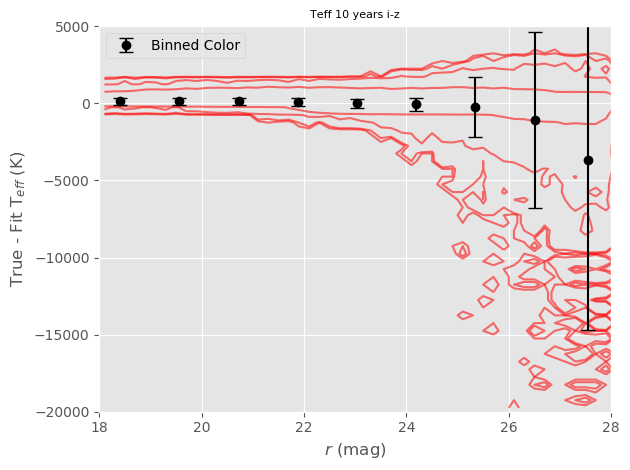

In [32]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], col4_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='r', levels=levels, alpha=.55)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  col4_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  col4_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years i-z', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/i-z_teff.pdf')

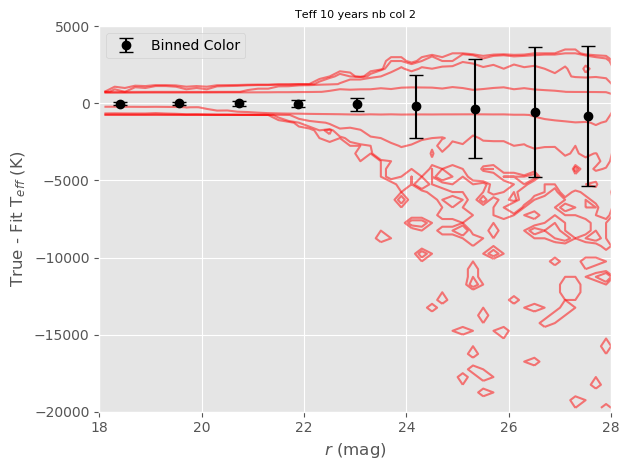

In [33]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_col2_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='r', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  nb_col2_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  nb_col2_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years nb col 2', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/nbcol2.pdf')

In [34]:
# that one's definitely better

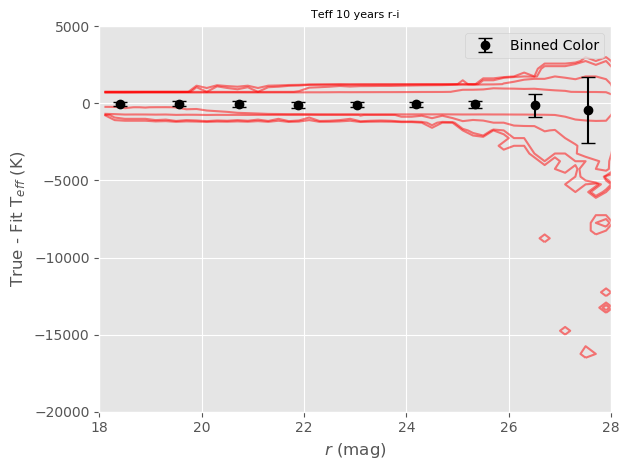

In [35]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], col3_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='r', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  col3_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  col3_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years r-i', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/r-i_teff.pdf')

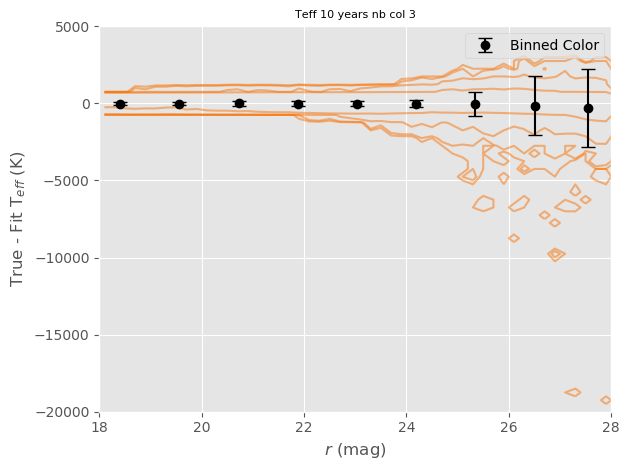

In [36]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_col3_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='xkcd:orange', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  nb_col3_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  nb_col3_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years nb col 3', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/nbcol3.pdf')

In [37]:
# that one's spectacular

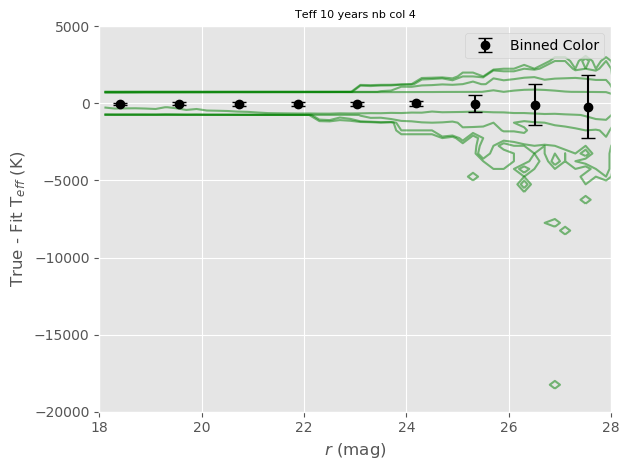

In [38]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_col4_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='g', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  nb_col4_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  nb_col4_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years nb col 4', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/nbcol4.pdf')

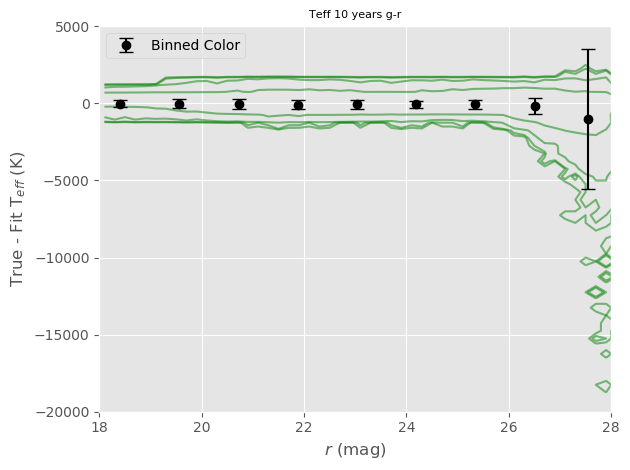

In [39]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], col2_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='g', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  col2_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  col2_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years g-r', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/g-r_teff.pdf')

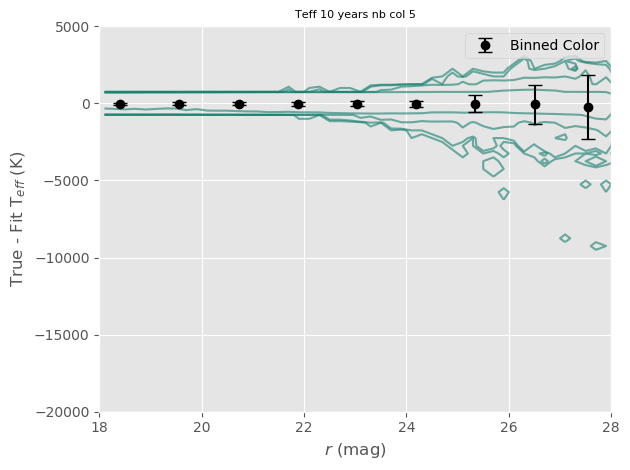

In [40]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_col5_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='xkcd:Blue Green', levels=levels, alpha=.6)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  nb_col5_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  nb_col5_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years nb col 5', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/nbcol5.pdf')

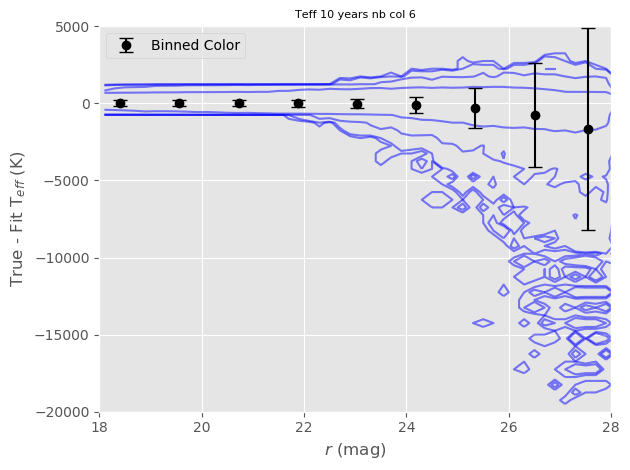

In [41]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_col6_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='b', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  nb_col6_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  nb_col6_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years nb col 6', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/nbcol6.pdf')

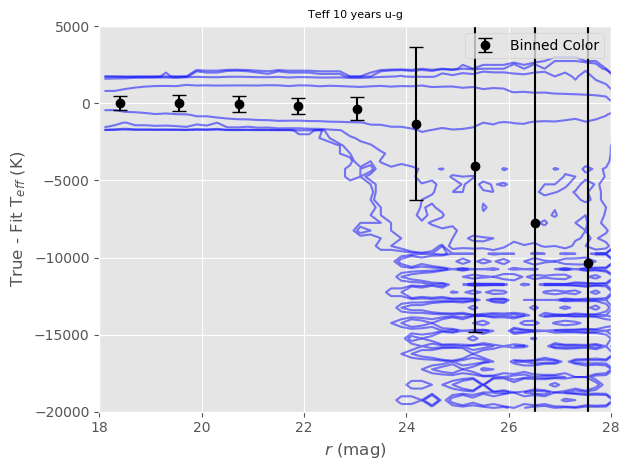

In [42]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], col1_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='b', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  col1_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  col1_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years u-g', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/u-g_teff.pdf')

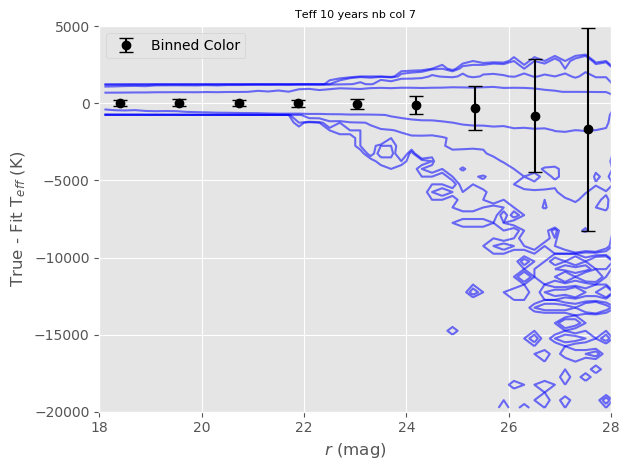

In [43]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_col7_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='b', levels=levels, alpha=.55)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  nb_col7_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  nb_col7_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$ (K)')
plt.title('Teff 10 years nb col 7', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/nbcol7.pdf')

## I'll try a couple filter combinations now:

In [44]:
good_model_nbcols = np.array(
    [model_ncolor2, model_ncolor3, model_ncolor4]
)
good_nbcols = np.array(
    [nbobscolor3, nbobscolor4, nbobscolor5]
)

tricolore = treeMaker(
    good_model_nbcols, good_nbcols, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff',
)

tricolore_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], tricolore[0], 1.0)
tricolore_std = tricolore_teff[1]
tricolore_mag = tricolore_teff[0]
tricolore_teff = tricolore_teff[2]
tricolore_teff_residuals = tricolore[1]

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

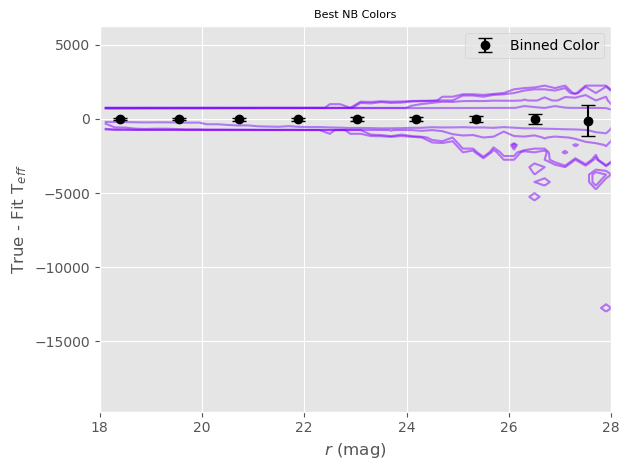

In [45]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], tricolore_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, cmap='rainbow', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  tricolore_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  tricolore_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
#plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$')
plt.title('Best NB Colors', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/tricolore.pdf')

### I actually want to try to zoom in a little more on the fainter end:

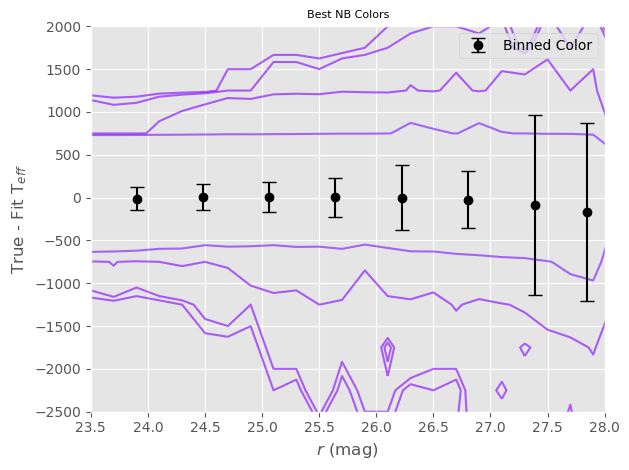

In [46]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], tricolore_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, cmap='rainbow', levels=levels, alpha=.6)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  tricolore_teff_residuals, statistic=np.mean, bins=38)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=38)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  tricolore_teff_residuals, statistic=np.std, bins=38)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(23.5, 28)
plt.ylim(-2500, 2000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$')
plt.title('Best NB Colors', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/tricolore.pdf')

## ugrizy colors and NB colors combined:

In [47]:
model_combo = np.array(
    [model_color1, model_color2, model_color3, model_color4, model_color5, model_ncolor2, model_ncolor3, model_ncolor4]
)

combination_cols = np.array(
    [obscolor1, obscolor2, obscolor3, obscolor4, obscolor5, nbobscolor2, nbobscolor3, nbobscolor4]
)

combination = treeMaker(model_combo, combination_cols, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff')

combination_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], combination[0], 1.0)
combination_std = combination_teff[1]
combination_mag = combination_teff[0]
combination_teff = combination_teff[2]
combination_teff_residuals = combination[1]

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

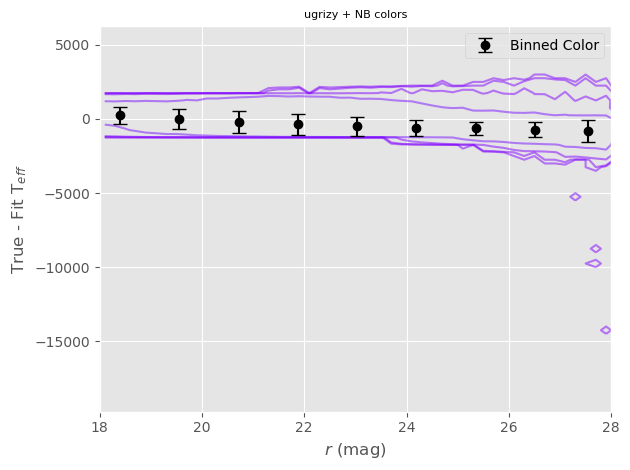

In [48]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], combination_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, cmap='rainbow', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  combination_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  combination_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
#plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$')
plt.title('ugrizy + NB colors', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/combination_teff.pdf')

Just checking how much all the ugrizy colors combined without NBs contribute on their own:

In [50]:
ugrizy = treeMaker(colormodel, obs_colors, true_catalog=truth_catalog, catalog=model_atm_mags, parameter='Teff')

ugrizy_teff = binnedFitParams(truth_catalog['r'], truth_catalog['Teff'], model_atm_mags['Teff'], ugrizy[0], 1.0)
ugrizy_std = ugrizy_teff[1]
ugrizy_mag = ugrizy_teff[0]
ugrizy_teff = ugrizy_teff[2]
ugrizy_teff_residuals = ugrizy[1]

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

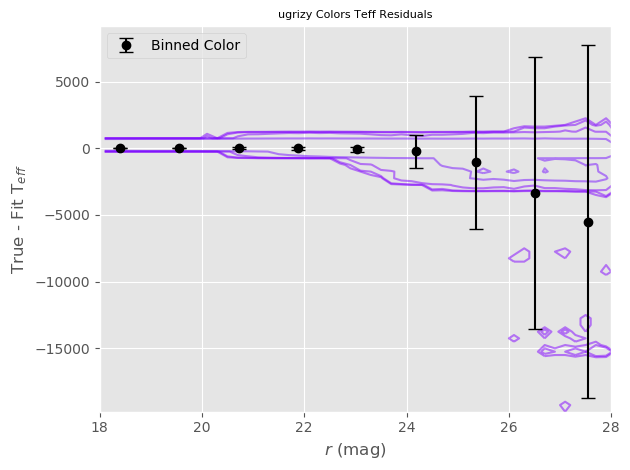

In [51]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-20000, 7000, 500)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], ugrizy_teff_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, cmap='rainbow', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  ugrizy_teff_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  ugrizy_teff_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
#plt.ylim(-20000, 5000)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit T$_{eff}$')
plt.title('ugrizy Colors Teff Residuals', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/ugrizy_teff.pdf')

Now a brief test of gravity and metallicity; who knows, maybe they get better on a filter-by filter basis (spoiler: they don't)?

### Gravity:

In [52]:
nb_col1_gravity = binnedFitParams(truth_catalog['r'], truth_catalog['gravity'], model_atm_mags['gravity'], nbcolor1[0], 1.0)
nb_col1_std = nb_col1_gravity[1]
nb_col1_mag = nb_col1_gravity[0]
nb_col1_gravity = nb_col1_gravity[2]
nb_col1_gravity_residuals = nbcolor1[2]

nb_col2_gravity = binnedFitParams(truth_catalog['r'], truth_catalog['gravity'], model_atm_mags['gravity'], nbcolor2[0], 1.0)
nb_col2_std = nb_col2_gravity[1]
nb_col2_mag = nb_col2_gravity[0]
nb_col2_gravity = nb_col2_gravity[2]
nb_col2_gravity_residuals = nbcolor2[2]

nb_col3_gravity = binnedFitParams(truth_catalog['r'], truth_catalog['gravity'], model_atm_mags['gravity'], nbcolor3[0], 1.0)
nb_col3_std = nb_col3_gravity[1]
nb_col3_mag = nb_col3_gravity[0]
nb_col3_gravity = nb_col3_gravity[2]
nb_col3_gravity_residuals = nbcolor3[2]

nb_col4_gravity = binnedFitParams(truth_catalog['r'], truth_catalog['gravity'], model_atm_mags['gravity'], nbcolor4[0], 1.0)
nb_col4_std = nb_col4_gravity[1]
nb_col4_mag = nb_col4_gravity[0]
nb_col4_gravity = nb_col4_gravity[2]
nb_col4_gravity_residuals = nbcolor4[2]

nb_col5_gravity = binnedFitParams(truth_catalog['r'], truth_catalog['gravity'], model_atm_mags['gravity'], nbcolor5[0], 1.0)
nb_col5_std = nb_col5_gravity[1]
nb_col5_mag = nb_col5_gravity[0]
nb_col5_gravity = nb_col5_gravity[2]
nb_col5_gravity_residuals = nbcolor5[2]

nb_col6_gravity = binnedFitParams(truth_catalog['r'], truth_catalog['gravity'], model_atm_mags['gravity'], nbcolor6[0], 1.0)
nb_col6_std = nb_col6_gravity[1]
nb_col6_mag = nb_col6_gravity[0]
nb_col6_gravity = nb_col6_gravity[2]
nb_col6_gravity_residuals = nbcolor6[2]

nb_col7_gravity = binnedFitParams(truth_catalog['r'], truth_catalog['gravity'], model_atm_mags['gravity'], nbcolor7[0], 1.0)
nb_col7_std = nb_col7_gravity[1]
nb_col7_mag = nb_col7_gravity[0]
nb_col7_gravity = nb_col7_gravity[2]
nb_col7_gravity_residuals = nbcolor7[2]

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

Plotting one:

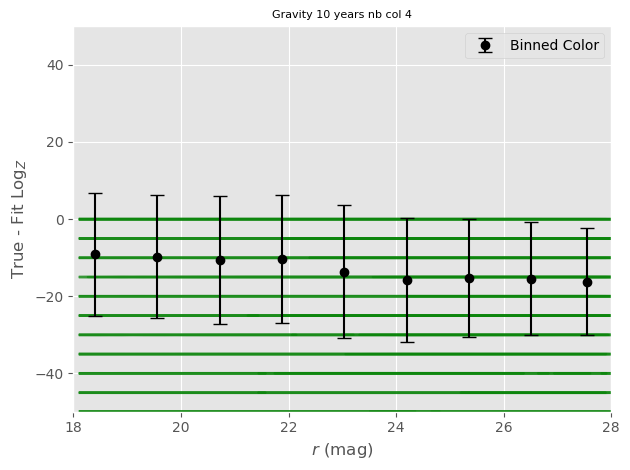

In [63]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-50, 5, .1)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_col4_gravity_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='g', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  nb_col4_gravity_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  nb_col4_gravity_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-50,50)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit Log$_{Z}$')
plt.title('Gravity 10 years nb col 4', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/nbcol4G.pdf')

Beautiful.

### Metallicity:

In [54]:
nb_col1_log_Z = binnedFitParams(truth_catalog['r'], truth_catalog['log_Z'], model_atm_mags['log_Z'], nbcolor1[0], 1.0)
nb_col1_std = nb_col1_log_Z[1]
nb_col1_mag = nb_col1_log_Z[0]
nb_col1_log_Z = nb_col1_log_Z[2]
nb_col1_log_Z_residuals = nbcolor1[3]

nb_col2_log_Z = binnedFitParams(truth_catalog['r'], truth_catalog['log_Z'], model_atm_mags['log_Z'], nbcolor2[0], 1.0)
nb_col2_std = nb_col2_log_Z[1]
nb_col2_mag = nb_col2_log_Z[0]
nb_col2_log_Z = nb_col2_log_Z[2]
nb_col2_log_Z_residuals = nbcolor2[3]

nb_col3_log_Z = binnedFitParams(truth_catalog['r'], truth_catalog['log_Z'], model_atm_mags['log_Z'], nbcolor3[0], 1.0)
nb_col3_std = nb_col3_log_Z[1]
nb_col3_mag = nb_col3_log_Z[0]
nb_col3_log_Z = nb_col3_log_Z[2]
nb_col3_log_Z_residuals = nbcolor3[3]

nb_col4_log_Z = binnedFitParams(truth_catalog['r'], truth_catalog['log_Z'], model_atm_mags['log_Z'], nbcolor4[0], 1.0)
nb_col4_std = nb_col4_log_Z[1]
nb_col4_mag = nb_col4_log_Z[0]
nb_col4_log_Z = nb_col4_log_Z[2]
nb_col4_log_Z_residuals = nbcolor4[3]

nb_col5_log_Z = binnedFitParams(truth_catalog['r'], truth_catalog['log_Z'], model_atm_mags['log_Z'], nbcolor5[0], 1.0)
nb_col5_std = nb_col5_log_Z[1]
nb_col5_mag = nb_col5_log_Z[0]
nb_col5_log_Z = nb_col5_log_Z[2]
nb_col5_log_Z_residuals = nbcolor5[3]

nb_col6_log_Z = binnedFitParams(truth_catalog['r'], truth_catalog['log_Z'], model_atm_mags['log_Z'], nbcolor6[0], 1.0)
nb_col6_std = nb_col6_log_Z[1]
nb_col6_mag = nb_col6_log_Z[0]
nb_col6_log_Z = nb_col6_log_Z[2]
nb_col6_log_Z_residuals = nbcolor6[3]

nb_col7_log_Z = binnedFitParams(truth_catalog['r'], truth_catalog['log_Z'], model_atm_mags['log_Z'], nbcolor7[0], 1.0)
nb_col7_std = nb_col7_log_Z[1]
nb_col7_mag = nb_col7_log_Z[0]
nb_col7_log_Z = nb_col7_log_Z[2]
nb_col7_log_Z_residuals = nbcolor7[3]

/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:140: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:110: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:132: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:21: RuntimeWarning: Mean of empty slice.
/Users/reformedfolloweroftheichorgodbel-shamharoth/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcou

Plotting one of the more-likely-to-be-okay ones to see what it looks like:

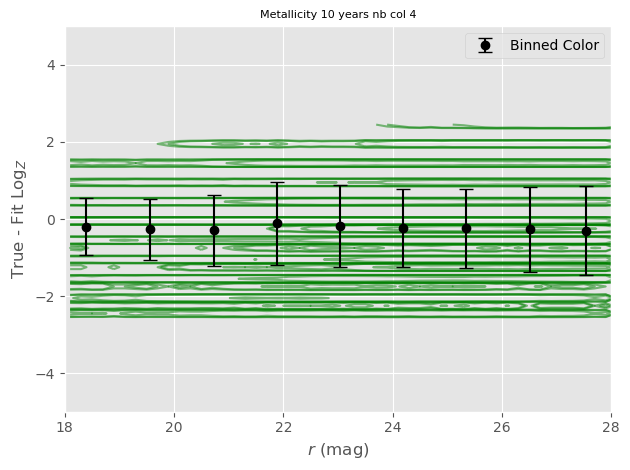

In [61]:
xedges = np.arange(18,29,.2)
yedges = np.arange(-2.6, 2.6, .1)

levels = [1, 2, 10, 100, 5000]

H, xedges, yedges = np.histogram2d(truth_catalog['r'], nb_col4_log_Z_residuals, bins=[xedges, yedges])
xcenters = (xedges[:-1] + xedges[1:]) / 2
ycenters = (yedges[:-1] + yedges[1:]) / 2
x,y = np.meshgrid(xcenters, ycenters)
#X, Y = np.meshgrid(xedges, yedges)
plt.contour(x,y,H.T, colors='g', levels=levels, alpha=.5)

broad_mean, bin_edges, binnum = binned_statistic(truth_catalog['r'],  nb_col4_log_Z_residuals, statistic=np.mean, bins=19)
broad_x, temp1, temp2 = binned_statistic(truth_catalog['r'], truth_catalog['r'], statistic=np.mean, bins=19)
broad_std, temp1, temp2 = binned_statistic(truth_catalog['r'],  nb_col4_log_Z_residuals, statistic=np.std, bins=19)

plt.errorbar(broad_x, broad_mean, yerr=broad_std,fmt='o',
             capsize=5, c='k', label='Binned Color')


leg = plt.legend()
for l in leg.legendHandles:
    l.set_alpha(1)
plt.xlim(18,28)
plt.ylim(-5,5)
plt.xlabel('$r$ (mag)')
plt.ylabel('True - Fit Log$_{Z}$')
plt.title('Metallicity 10 years nb col 4', fontsize=8)
plt.tight_layout();
#plt.savefig('./current_figs/nbcol4Z.pdf')

# Okay those don't look any better on their own than they did before. Oh well, good to check.